In [2]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
import porepy as pp

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


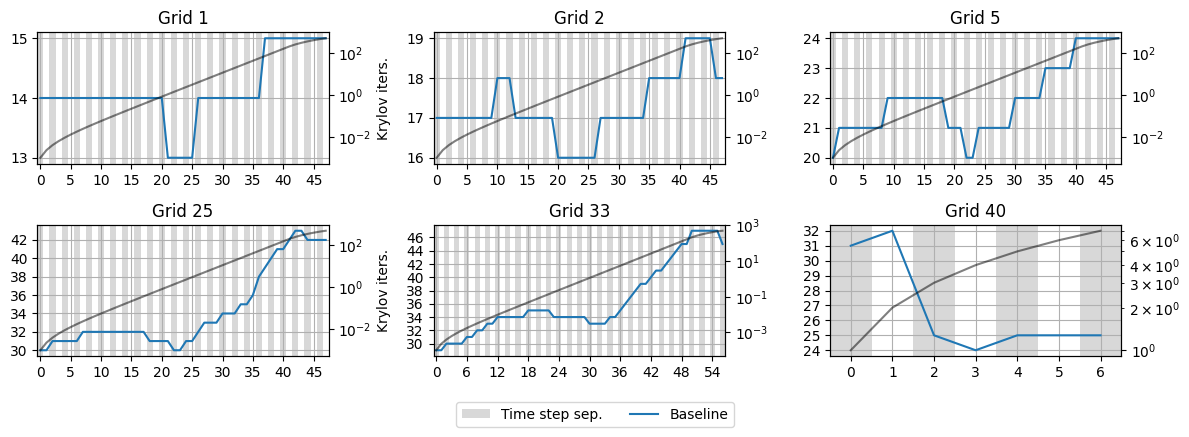

In [12]:
grids = [
    1,
    2,
    5,
    25,
    33,
    40,
]

s = 5

data = {}
names = {}
for i, g in enumerate(grids):
    try:
        data[i] = load_data(f"../stats/stats_thermal_geonofracx{g}_sol{s}.json")
        names[i] = f"Grid {g}"
    except:
        continue


shape = [2, 3]
figsize = (12, 4)


def render_element(i, data):
    color_time_steps(data, fill=True, legend=True)
    # color_converged_reason(data[0], legend=True)
    plt.gca().grid(True)
    set_integer_ticks("vertical")
    plt.plot(get_gmres_iterations(data), label='Baseline')
    # plt.plot(get_gmres_iterations(data[1]), label='Thermal FS', linestyle='--')
    plt.twinx()
    DAY = 3600 * 24
    plt.plot(np.cumsum(get_time_steps(data)) / DAY , color='black', alpha=0.5, label='Time')
    plt.yscale('log')


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

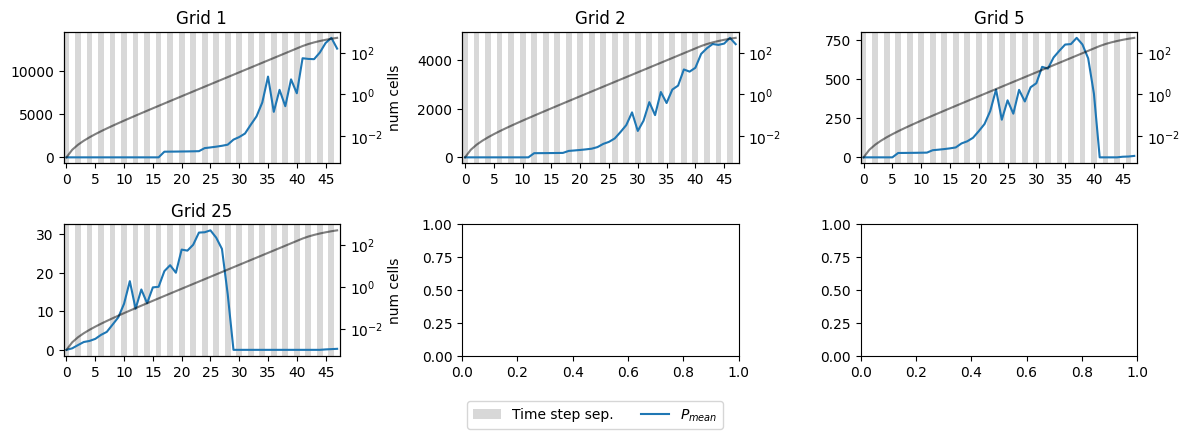

In [11]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    color_time_steps(entry, fill=True, grid=False, legend=True)
    cfl = get_cfl(entry)
    peclet_max = get_peclet_max(entry)
    peclet_mean = get_peclet_mean(entry)
    # plt.plot(cfl, label='CFL')
    # plt.twinx()
    # plt.plot(peclet_max, label=r'$P_{max}$')
    # plt.yscale('log')
    # plt.ylim(bottom=1e-2)
    plt.plot(peclet_mean, label=r'$P_{mean}$')
    plt.twinx()
    DAY = 3600 * 24
    plt.plot(np.cumsum(get_time_steps(entry)) / DAY , color='black', alpha=0.5, label='Time')
    plt.yscale('log')
    # st, sl, op = get_num_sticking_sliding_open(entry)
    # plt.gca().grid(False)
    # plt.gca().grid(True, which="major", axis="y")
    # marker = None
    # plt.plot(st, label="Sticking", marker=marker, color=COLOR_STICKING)
    # plt.plot(sl, label="Sliding", marker=marker, color=COLOR_SLIDING)
    # plt.plot(op, label="Open", marker=marker, color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)


plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="num cells",
    ax_titles=names,
    #   ylabel="Fract. len., m"
)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

In [12]:
from collections import defaultdict
import pandas as pd

table = defaultdict(lambda: [])

NDIGITS = 1

for g in grids:
    stats_name = f"stats_thermal_geonofracx{g}_sol{s}.json"
    entry = load_data(f"../stats/{stats_name}")
    dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
    total_dofs = dofs_info["total dofs"]
    table["Total DoFs"].append(int(total_dofs))

    # if g in [1, 2, 5]:
    #     direct = load_data(f"../stats/stats_geo0x{g}_sol{21}_ph{1}_bb{2}_fr{1}.json")
    #     table["GMRES dir."].append(round(np.mean(get_gmres_iterations(direct)), NDIGITS))
    # else:
    #     table["GMRES dir."].append('-')

    table["GMRES AMG"].append(round(np.mean(get_gmres_iterations(entry)), NDIGITS))
    table['Newton iters.'].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))
    converged_reason = get_petsc_converged_reason(entry)
    # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table).T
table.rename(columns=table.iloc[0], inplace=True)
table = table[1:]
table.columns.name = 'Total DoFs'
table

FileNotFoundError: [Errno 2] No such file or directory: '../stats/stats_thermal_geonofracx33_sol6.json'

In [9]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_runscript_nofrac import make_model
import porepy as pp

model = make_model(
    {
        "geometry": "nofrac",
        "grid_refinement": 1,
        "solver": 3,
        "save_matrix": False,
        "steady_state": False,
        "initial_state": "ignore",
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.00e+00, Dt: 1.00e-03 (days)
Temperature: 0.00, 0.00
Peclet: 1.5e+05, CFL: 3.2e-04
sticking: 0, sliding: 0, open: 0


/home/porepy/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/porepy/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    # '../stats/stats_thermal_geonofracx1_sol4_1738425817582.json'
    # load_data(),
    load_data(f"../stats/{model.simulation_name()}.json"),
    30,
)

IsADirectoryError: [Errno 21] Is a directory: '../matrices'

In [ ]:
model.linear_system = mat, rhs
model.bmat.mat = mat
model.equation_system.set_variable_values(state, time_step_index=0)
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.ad_time_step.set_value(dt)
model.time_manager.dt = dt
model.discretize()

NameError: name 'mat' is not defined

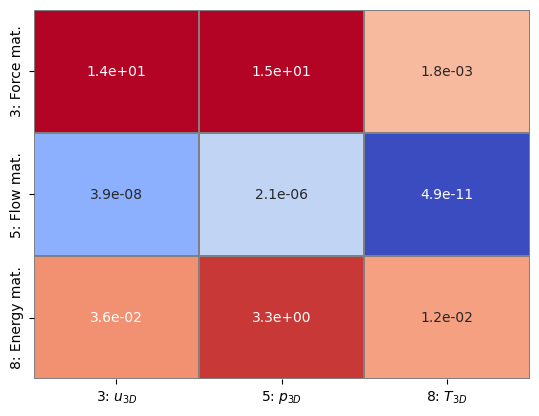

In [10]:
J = model.bmat[:]
J.plot_max()

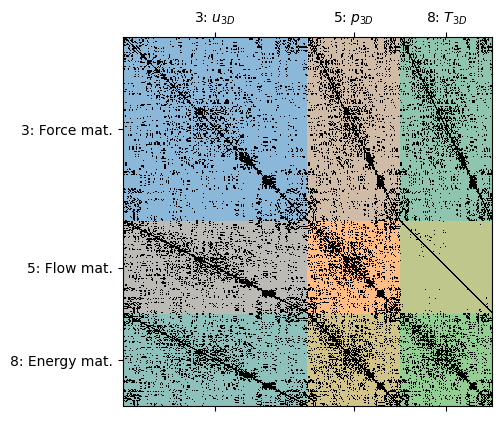

In [11]:
J.color_spy()

In [30]:
from fixed_stress import make_fs_analytical_slow_new, make_fs_thermal
from full_petsc_solver import *
from thermal.thm_solver import make_pt_permutation

model = model
contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]


scheme = LinearTransformedScheme(
    right_transformations=[lambda bmat: model.Qright(contact_group=0, u_intf_group=4)],
    inner=PetscKSPScheme(
        petsc_options={
            "ksp_monitor": None,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=contact,
            # block_size=model.nd,
            # fieldsplit_options={
            #     "pc_fieldsplit_schur_precondition": "selfp",
            # },
            # subsolver_options={
            #     "pc_type": "pbjacobi",
            # },
            # tmp_options={
            #     "mat_schur_complement_ainv_type": "blockdiag",
            # },
            # complement=PetscFieldSplitScheme(
            #     groups=intf,
            #     subsolver_options={
            #         "pc_type": "ilu",
            #     },
            #     fieldsplit_options={
            #         "pc_fieldsplit_schur_precondition": "selfp",
            #     },
            #     complement=PetscFieldSplitScheme(
            #         groups=mech,
            #         subsolver_options=(
            #             {
            #                 "pc_type": "hypre",
            #                 "pc_hypre_type": "boomeramg",
            #                 "pc_hypre_boomeramg_strong_threshold": 0.7,
            #                 "pc_hypre_boomeramg_smooth_type": "Euclid",
            #             }
            #         ),
            #         tmp_options={},
            #         block_size=model.nd,
            #         invert=lambda bmat: csr_to_petsc(
            #             make_fs_analytical_slow_new(
            #                 model,
            #                 bmat,
            #                 p_mat_group=5,
            #                 p_frac_group=6,
            #                 groups=flow + temp,
            #             ).mat,
            #             bsize=1,
            #         ),
                    complement=PetscFieldSplitScheme(
                        groups=flow + temp,
                        python_pc=lambda bmat: PcPythonPermutation(
                            make_pt_permutation(bmat), block_size=2
                        ),
                        subsolver_options={
                            # "pc_type": "hypre",
                            # "pc_hypre_type": "euclid",
                            "python_pc_type": "spai",
                            # 'python_pc_hypre_type': 'boomeramg',
                            # "python_pc_hypre_type": "pilut",
                            # 'python_pc_hypre_boomeramg_nodal_coarsen': 1,
                            # 'python_pc_hypre_boomeramg_vec_interp_variant': 1,
                            # "python_pc_hypre_euclid_bj": True,
                        },
                    ),
            #     ),
            # ),
        ),
    ),
)

ksp = solve_petsc_3(J, rhs, scheme, ksp_view=True, options_view=True, return_data=True)

Error: error code 86
[0] PCSetFromOptions() at /home/porepy/petsc/src/ksp/pc/interface/pcset.c:156
[0] PCSetFromOptions() at /home/porepy/petsc/src/ksp/pc/interface/pcset.c:146
[0] PCSetType() at /home/porepy/petsc/src/ksp/pc/interface/pcset.c:59
[0] Unknown type. Check for miss-spelling or missing package: https://petsc.org/release/install/install/#external-packages
[0] Unable to find requested PC type spai

array([ 693,  695,  697,  699,  701,  703,  705,  707,  709,  711,  713,
        715,  717,  719,  721,  723,  725,  727,  729,  731,  733,  735,
        737,  739,  741,  743,  745,  747,  749,  751,  753,  755,  757,
        759,  761,  763,  765,  767,  769,  771,  773,  775,  777,  779,
        781,  783,  785,  787,  789,  791,  793,  795,  797,  799,  801,
        803,  805,  807,  809,  811,  813,  815,  817,  819,  821,  823,
        825,  827,  829,  831,  833,  835,  837,  839,  841,  843,  845,
        847,  849,  851,  853,  855,  857,  859,  861,  863,  865,  867,
        869,  871,  873,  875,  877,  879,  881,  883,  885,  887,  889,
        891,  893,  895,  897,  899,  901,  903,  905,  907,  909,  911,
        913,  915,  917,  919,  921,  923,  925,  927,  929,  931,  933,
        935,  937,  939,  941,  943,  945,  947,  949,  951,  953,  955,
        957,  959,  961,  963,  965,  967,  969,  971,  973,  975,  977,
        979,  981,  983,  985,  987,  989,  991,  9

In [87]:
J1.local_dofs_row

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [ ]:
J

In [17]:
J.groups_to_blocks_row[0]

[]

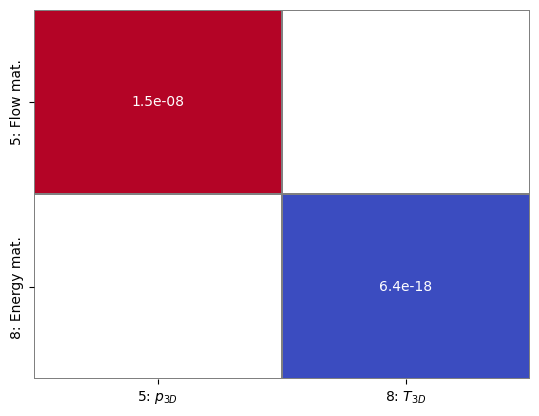

In [8]:
from fixed_stress import (
    get_fixed_stress_stabilization,
    make_fs_analytical,
    make_fs_thermal,
)
from mat_utils import *
from block_matrix import *


def make_stab(bmat: BlockMatrixStorage, keep: list[int], elim: list[int]):
    stab = bmat[keep].empty_container()
    inv_ = inv_block_diag(bmat[elim].mat, nd=model.nd)
    stab.mat -= bmat[keep, elim].mat @ inv_ @ bmat[elim, keep].mat
    return stab


# elim = [0, 1, 2, 3, 4]
# keep = [5, 6, 8, 9]
p = [5]
T = [8]
elim = [3]
keep = p + T
# stab1 = make_stab(J, elim=elim, keep=keep)
# stab1.set_zeros(p, p)
# stab1.set_zeros(p, T)
# stab1.set_zeros(T, p)
# stab1.set_zeros(T, T)

stab1 = make_fs_thermal(
    model,
    J,
    groups=keep,
    p_mat_group=5,
    p_frac_group=-1,
    t_mat_group=8,
    t_frac_group=-1,
)
stab1.plot_max()

S = J[keep].copy()
S.mat += stab1.mat

ksp_type fgmres
ksp_pc_side right
ksp_rtol 1e-10
ksp_max_it 120
ksp_gmres_cgs_refinement_type refine_ifneeded
ksp_gmres_classicalgramschmidt True
pc_type fieldsplit
pc_fieldsplit_type schur
pc_fieldsplit_schur_precondition user
pc_fieldsplit_schur_fact_type upper
fieldsplit_3-4_ksp_type gmres
fieldsplit_3-4_pc_type hypre
fieldsplit_5-6-7-8-9-10_ksp_type preonly
fieldsplit_3-4_ksp_rtol 0.01
fieldsplit_3-4_ksp_pc_side right
fieldsplit_3-4_pc_hypre_type boomeramg
fieldsplit_3-4_pc_hypre_boomeramg_strong_threshold 0.6
fieldsplit_3-4_pc_hypre_boomeramg_P_max 1
fieldsplit_3-4_pc_hypre_boomeramg_max_iter 1
fieldsplit_3-4_pc_hypre_boomeramg_cycle_type W
fieldsplit_5-6-7-8-9-10_pc_type composite
fieldsplit_5-6-7-8-9-10_pc_composite_type multiplicative
fieldsplit_5-6-7-8-9-10_pc_composite_pcs fieldsplit,ksp
fieldsplit_5-6-7-8-9-10_sub_0_pc_fieldsplit_type additive
fieldsplit_5-6-7-8-9-10_sub_1_ksp_ksp_pc_side right
fieldsplit_5-6-7-8-9-10_sub_1_ksp_ksp_rtol 0.01
fieldsplit_5-6-7-8-9-10_sub_1_ksp

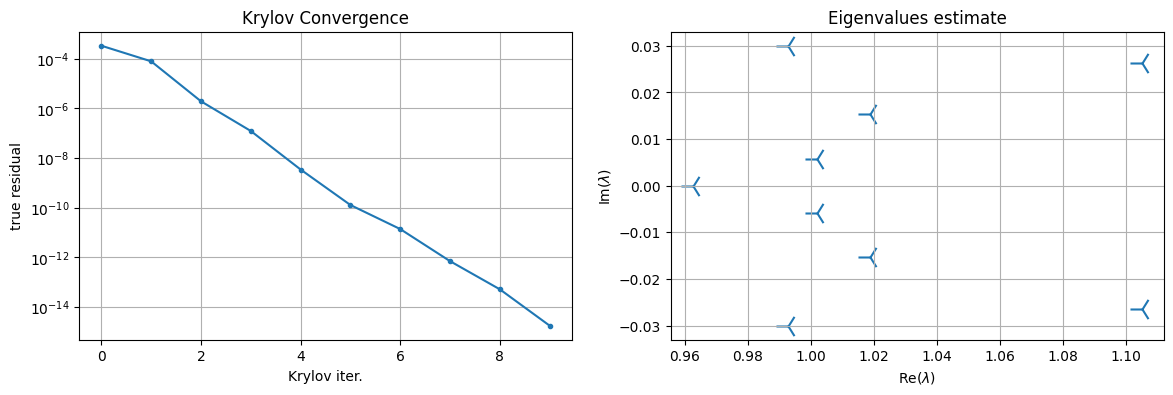

In [ ]:
from fixed_stress import make_fs_thermal
from full_petsc_solver import *

model = model
contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]

scheme = LinearTransformedScheme(
    # right_transformations=[lambda bmat: self.Qright(contact_group=0, u_intf_group=4)],
    inner=PetscKSPScheme(
        petsc_options={
            "ksp_type": "fgmres",
            # 'ksp_type': 'richardson',
            # 'ksp_pc_side': 'left',
            # "ksp_monitor": None,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=mech,
            subsolver_options={
                'ksp_type': 'gmres',
                'ksp_rtol': 1e-2,
                'ksp_pc_side': 'right',
                # 'ksp_monitor': None,
                # # old
                "pc_type": "hypre",
                "pc_hypre_type": "boomeramg",
                "pc_hypre_boomeramg_strong_threshold": 0.6,
                # not sure:
                "pc_hypre_boomeramg_P_max": 1,
                'pc_hypre_boomeramg_max_iter': 1, 
                'pc_hypre_boomeramg_cycle_type': 'W',
            },
            tmp_options={
                # 'ksp_type': 'gmres',
                # 'ksp_rtol': 1e-3,
                # 'ksp_pc_side': 'right',
                # 'ksp_monitor': None,
            },
            block_size=model.nd,
            invert=lambda bmat: csr_to_petsc(
                make_fs_thermal(
                    model,
                    bmat,
                    p_mat_group=5,
                    p_frac_group=-1,
                    t_mat_group=8,
                    t_frac_group=-1,
                    groups=flow + temp,
                ).mat * 1,
                bsize=1,
            ),
            complement=PetscCPRScheme(
                groups=flow + temp,
                pressure_groups=flow,
                pressure_options={
                    # 'ksp_type': 'gmres',
                    # 'ksp_rtol': 1e-8,
                    # 'ksp_pc_side': 'right',
                    # 'ksp_monitor': None,
                    "pc_type": "hypre",
                    "pc_hypre_type": "boomeramg",
                },
                others_options={
                    "ksp_type": "preonly",
                    "pc_type": "none",
                },
                cpr_options={
                    "pc_composite_pcs": "fieldsplit,ksp",
                    'sub_1_ksp_ksp_pc_side': 'right',
                    'sub_1_ksp_ksp_rtol': 1e-2,
                    'sub_1_ksp_pc_type': 'hypre',
                    'sub_1_ksp_pc_hypre_type': "Euclid",
                    'sub_1_ksp_ksp_monitor': None,
                    'sub_1_ksp_ksp_max_it': 120,
                    # 
                    # "pc_composite_pcs": "fieldsplit,ilu",
                    # "pc_composite_pcs": "fieldsplit,hypre",
                    # 'sub_1_pc_hypre_type': 'Euclid',
                },
            ),
        ),
    ),
)

ksp = solve_petsc_3(J, rhs, scheme, ksp_view=True, options_view=True, return_data=True)

In [101]:
ksp.ksp